In [402]:
import mdtraj as md 
from ase import Atoms
from nglview import show_ase
import networkx as nx

import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import  GCNConv,BatchNorm
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.preprocessing import MinMaxScaler

In [403]:
# load alanine dipeptide trajectory 
molecule = md.load_pdb("../simulation/single.pdb")

In [404]:
atomic_nums = [atom.element.atomic_number for atom in molecule.top.atoms] 
water = Atoms(positions= molecule.xyz[0], numbers=atomic_nums)
show_ase(water)

NGLWidget()

In [405]:
molecule.xyz*10

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.957     ,  0.        ,  0.        ],
        [-0.23900001,  0.926     ,  0.        ],
        [ 0.        ,  0.46      ,  0.32000002]]], dtype=float32)

In [406]:
def rotate3D(features,psi,theta,phi):
    xyz = features[:,:3]
    rest = features[:,3:]
    matrix = np.array([[np.cos(psi)*np.cos(phi)-np.cos(theta)*np.sin(phi)*np.sin(psi),np.cos(psi)*np.sin(phi)+np.cos(theta)*np.cos(phi)*np.sin(psi),np.sin(psi)*np.sin(theta)],
                          [-np.sin(psi)*np.cos(phi)-np.cos(theta)*np.sin(phi)*np.cos(psi),-np.sin(psi)*np.sin(phi)+np.cos(theta)*np.cos(phi)*np.cos(psi),np.cos(psi)*np.sin(theta)],
                            [np.sin(theta)*np.sin(phi),-np.sin(theta)*np.cos(phi),np.cos(theta)]])
    return np.concatenate((np.dot(xyz,matrix) *10 , rest),axis=1) 

In [407]:

# atomic Number
atomic_nums = np.array([[atom.element.atomic_number for atom in molecule.top.atoms]]).T

# Vander wall Radii
vdwr = np.array([[atom.element.radius for atom in molecule.top.atoms]]).T

# Atomic Mass 
mass = np.array([[atom.element.mass for atom in molecule.top.atoms]]).T

atom_type = np.array([[2,1,1,0]]).T

# Relative position of atoms on one molecule
poitions = molecule.xyz[0]*10
# calculate weighted average of the positions of the atoms in the molecule
com = np.average(poitions, axis=0, weights=mass.T[0])
# relative position of atoms in the molecule

relative_pos = poitions-com


print("Absolute positions:\n",poitions)
print("\nRelative positions:\n",relative_pos)
print("\natomic_numbers:\n",atomic_nums)
print("\nVander wall Radii:\n", vdwr)
print("\nAtomic Mass:\n",mass)

Absolute positions:
 [[ 0.          0.          0.        ]
 [ 0.957       0.          0.        ]
 [-0.23900001  0.926       0.        ]
 [ 0.          0.46        0.32000002]]

Relative positions:
 [[-0.04017169 -0.05180917  0.        ]
 [ 0.91682833 -0.05180917  0.        ]
 [-0.27917169  0.87419083  0.        ]
 [-0.04017169  0.40819084  0.32000002]]

atomic_numbers:
 [[8]
 [1]
 [1]
 [0]]

Vander wall Radii:
 [[0.152]
 [0.12 ]
 [0.12 ]
 [0.   ]]

Atomic Mass:
 [[15.99943 ]
 [ 1.007947]
 [ 1.007947]
 [ 0.      ]]


In [408]:
node_features = np.concatenate((relative_pos,vdwr,atom_type),axis=1)
print("Node Features:\n",node_features)

Node Features:
 [[-0.04017169 -0.05180917  0.          0.152       2.        ]
 [ 0.91682833 -0.05180917  0.          0.12        1.        ]
 [-0.27917169  0.87419083  0.          0.12        1.        ]
 [-0.04017169  0.40819084  0.32000002  0.          0.        ]]


In [409]:
normalized_node_features = (node_features - node_features.min(axis=0))/(node_features.max(axis=0)-node_features.min(axis=0))
print("Normalized Node Features:\n",normalized_node_features)

Normalized Node Features:
 [[0.19983278 0.         0.         1.         1.        ]
 [1.         0.         0.         0.78947368 0.5       ]
 [0.         1.         0.         0.78947368 0.5       ]
 [0.19983278 0.49676027 1.         0.         0.        ]]


In [410]:
from_list = []
to_list = []
for edge in molecule.topology.bonds:
  from_list.append(edge.atom1.index)
  to_list.append(edge.atom2.index)
  from_list.append(edge.atom2.index)
  to_list.append(edge.atom1.index)

edge_list = np.array([from_list,to_list])

In [411]:
graph = data.Data(x=torch.from_numpy(normalized_node_features),edge_index=torch.from_numpy(edge_list))

In [412]:
print(graph)

Data(x=[4, 5], edge_index=[2, 4])


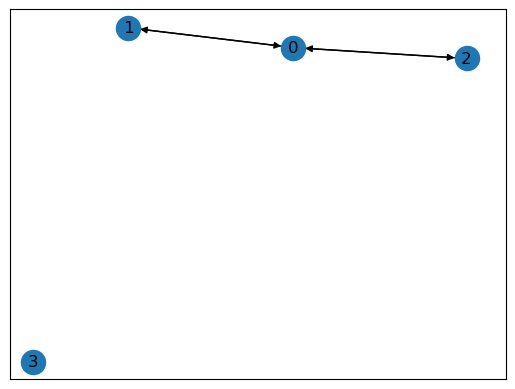

In [413]:
vis = to_networkx(graph)
nx.draw_networkx(vis)

In [414]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

In [415]:
graphs = []
n_graphs = 5000

In [416]:
all_features = []
real_node_features = []

for i in range(n_graphs):
    rotated = rotate3D(node_features,np.random.uniform(0,2*np.pi),np.random.uniform(0,2*np.pi),np.random.uniform(0,2*np.pi))
    real_node_features.append(rotated)

    noisy_node_features = rotated + np.random.normal(0,0.1,rotated.shape)

    all_features.append(noisy_node_features)
    real_node_features.append(rotated)

all_features = np.array(all_features)    
real_node_features = np.array(real_node_features)

In [417]:
scaler = MinMaxScaler()
scaler.fit(all_features.reshape(-1,1))
normalized_node_features = scaler.transform(all_features.reshape(-1,1)).reshape(all_features.shape)

normalized_real_node_features = scaler.transform(real_node_features.reshape(-1,1)).reshape(real_node_features.shape)


In [418]:
for x,y in zip(normalized_node_features,normalized_real_node_features):
    graph = data.Data(x=torch.from_numpy(x),edge_index=torch.from_numpy(edge_list),y=torch.from_numpy(y))
    graphs.append(graph)
    

In [419]:
from typing import Optional, Tuple 

import torch
from torch import Tensor
from torch.nn import Module

from torch_geometric.nn.inits import reset
from torch_geometric.utils import negative_sampling

EPS = 1e-15
MAX_LOGSTD = 10


class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""

    def forward(self, z: Tensor, edge_index: Tensor,
                sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z: Tensor, sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj


class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (torch.nn.Module): The encoder module.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        reset(self.encoder)
        reset(self.decoder)

    def forward(self, *args, **kwargs) -> Tensor:  # pragma: no cover
        r"""Alias for :meth:`encode`."""
        return self.encoder(*args, **kwargs)

    def encode(self, *args, **kwargs) -> Tensor:
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)

    def decode(self, *args, **kwargs) -> Tensor:
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)

    def recon_loss(self, z: Tensor, pos_edge_index: Tensor,
                   neg_edge_index: Optional[Tensor] = None) -> Tensor:
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to train against.
            neg_edge_index (torch.Tensor, optional): The negative edges to
                train against. If not given, uses negative sampling to
                calculate negative edges. (default: :obj:`None`)
        """
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True)[0] + EPS).mean()

        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index.long(), sigmoid=True)[0] +
                              EPS).mean()

        return pos_loss + neg_loss

    def test(self, z: Tensor, pos_edge_index: Tensor,
             neg_edge_index: Tensor) -> Tuple[Tensor, Tensor]:
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        
        scores.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to evaluate
                against.
            neg_edge_index (torch.Tensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import average_precision_score, roc_auc_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)


class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (torch.nn.Module): The encoder module to compute :math:`\mu`
            and :math:`\log\sigma^2`.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__(encoder, decoder)

    def reparametrize(self, mu: Tensor, logstd: Tensor) -> Tensor:
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def encode(self, *args, **kwargs) -> Tensor:
        """"""
        self.__mu__, self.__logstd__, self.edge_index = self.encoder(
            *args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z, self.edge_index

    def kl_loss(self, mu: Optional[Tensor] = None,
                logstd: Optional[Tensor] = None) -> Tensor:
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (torch.Tensor, optional): The latent space for :math:`\mu`. If
                set to :obj:`None`, uses the last computation of :math:`\mu`.
                (default: :obj:`None`)
            logstd (torch.Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`. (default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))


In [420]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.bn1 = BatchNorm(2 * out_channels)
        self.conv2 = GCNConv(2*out_channels, 1 * out_channels)
        self.bn2 = BatchNorm(1 * out_channels)
        self.linear1 = torch.nn.Linear(1 * out_channels, out_channels)
        self.conv_mu = GCNConv(1 * out_channels, out_channels)
        self.conv_logstd = GCNConv(1 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.bn1(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.bn2(x)
        
        x = self.linear1(x)
        x = F.sigmoid(x)
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index), edge_index


In [421]:
class VariationalGCNDecoder(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels)
        self.linear1 = torch.nn.Linear(2* out_channels, out_channels)
        self.linear2 = torch.nn.Linear(out_channels, out_channels)
    def forward(self, x, edge_index, sigmoid=True):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.sigmoid(x)
        return x, edge_index

In [422]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [423]:
in_channels = graph.num_features
out_channels = 2
lr = 1e-3
n_epochs = 100
batch_size=64
test_train_split = 0.8

model = VGAE(VariationalGCNEncoder(in_channels, out_channels),
             VariationalGCNDecoder(out_channels, in_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

In [424]:
split = int(test_train_split * len(graphs))
train_loader = DataLoader(graphs[:split], batch_size=batch_size)
test_loader = DataLoader(graphs[split:], batch_size=batch_size)

In [425]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.double()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    position_loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]

        positionLoss = lossFxn(decoded_pos, orignal_pos)
        FeatureLoss = lossFxn(decoded_features, orignal_features)

        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss
        # loss = loss + (1 / data.num_nodes) * model.kl_loss()
        loss = FeatureLoss + 2*positionLoss
        
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss())
        position_loss_all += float(positionLoss)

        loss.backward()
        optimizer.step()

    return loss_all / len(train_loader), feature_loss_all / len(train_loader), edge_loss_all / len(train_loader), kl_loss_all / len(train_loader),position_loss_all / len(train_loader)

In [426]:
lossFxn = torch.nn.MSELoss()
def test():
    model.eval()
    model.double()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    position_loss_all = 0

    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]

        positionLoss = lossFxn(decoded_pos, orignal_pos)
        FeatureLoss = lossFxn(decoded_features, orignal_features)

        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss
        # loss = loss + (1 / data.num_nodes) * model.kl_loss()
        loss = FeatureLoss + 2*positionLoss
        
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss())
        position_loss_all += float(positionLoss)



    return loss_all / len(test_loader), feature_loss_all / len(test_loader), edge_loss_all / len(test_loader), kl_loss_all / len(test_loader),position_loss_all / len(test_loader)

In [427]:
train_total_losses = []
train_feature_losses = []
train_edge_losses = []
train_kl_losses = []
train_position_losses = []

test_total_losses = []
test_feature_losses = []
test_edge_losses = []
test_kl_losses = []
test_position_losses = []

early_stopper = EarlyStopper(patience=3, min_delta=10)


for epoch in range(1, n_epochs + 1):
    train_total_loss, train_feature_loss, train_edge_loss, train_kl_loss,train_position_loss = train()
    test_total_loss, test_feature_loss, test_edge_loss, test_kl_loss,test_position_loss = test()
    
    print(f"Epoch: {epoch:03d}")
    print(f'\tTrain:\tTotal Loss: {train_total_loss:.4f}, Feature Loss: {train_feature_loss:.4f}, Edge Loss: {train_edge_loss:.4f}, KL Loss: {train_kl_loss:.4f} Position Loss: {train_position_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
    print(f'\tTest: \tTotal Loss: {test_total_loss:.4f}, Feature Loss: {test_feature_loss:.4f}, Edge Loss: {test_edge_loss:.4f}, KL Loss: {test_kl_loss:.4f} Position Loss: {test_position_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
    
    if(early_stopper.early_stop(test_total_loss)):
        print("Early Stopping")
        break

    train_total_losses.append(train_total_loss)
    train_feature_losses.append(train_feature_loss)
    train_edge_losses.append(train_edge_loss)
    train_kl_losses.append(train_kl_loss)
    train_position_losses.append(train_position_loss)

    test_total_losses.append(test_total_loss)
    test_feature_losses.append(test_feature_loss)
    test_edge_losses.append(test_edge_loss)
    test_kl_losses.append(test_kl_loss)
    test_position_losses.append(test_position_loss)
    
    scheduler.step()


/home2/anaconda3/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 001
	Train:	Total Loss: 0.1085, Feature Loss: 0.0082, Edge Loss: 0.0000, KL Loss: 1.2626 Position Loss: 0.0502, LR: 0.001000
	Test: 	Total Loss: 0.1042, Feature Loss: 0.0070, Edge Loss: 0.0000, KL Loss: 1.4127 Position Loss: 0.0486, LR: 0.001000
Epoch: 002
	Train:	Total Loss: 0.0998, Feature Loss: 0.0062, Edge Loss: 0.0000, KL Loss: 2.3170 Position Loss: 0.0468, LR: 0.001000
	Test: 	Total Loss: 0.0950, Feature Loss: 0.0056, Edge Loss: 0.0000, KL Loss: 2.8884 Position Loss: 0.0447, LR: 0.001000
Epoch: 003
	Train:	Total Loss: 0.0927, Feature Loss: 0.0047, Edge Loss: 0.0000, KL Loss: 3.3649 Position Loss: 0.0440, LR: 0.001000
	Test: 	Total Loss: 0.0895, Feature Loss: 0.0040, Edge Loss: 0.0000, KL Loss: 3.7767 Position Loss: 0.0428, LR: 0.001000
Epoch: 004
	Train:	Total Loss: 0.0870, Feature Loss: 0.0032, Edge Loss: 0.0000, KL Loss: 4.2767 Position Loss: 0.0419, LR: 0.001000
	Test: 	Total Loss: 0.0849, Feature Loss: 0.0027, Edge Loss: 0.0000, KL Loss: 4.7071 Position Loss: 0.0411, L

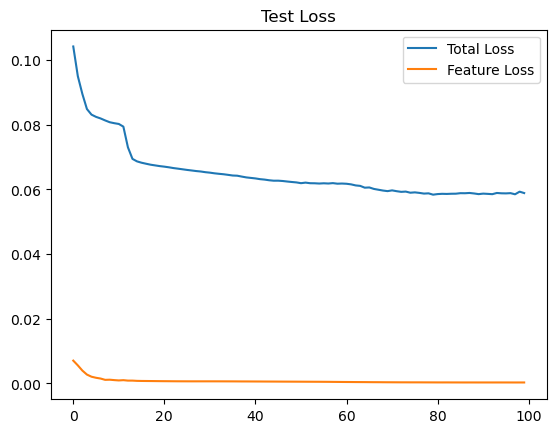

In [428]:
plt.plot(test_total_losses)
plt.plot(test_feature_losses)
# plt.plot(edge_losses)
# plt.plot(kl_losses)
plt.title("Test Loss")
plt.legend(['Total Loss', 'Feature Loss', 'KL Loss'])
plt.show()

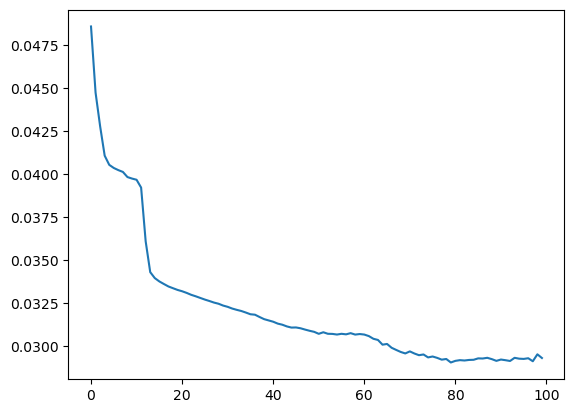

In [429]:
plt.plot(test_position_losses)
# atomic radius of oxygen is 0.74 Angstrom
# atomic radius of hydrogen is 0.53 Angstrom


In [432]:
ind = 5
test_graph = test_loader.dataset[ind]

model.double()
z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)

print(test_graph.x)
print(z)
print(decoded_x)

tensor([[0.4939, 0.4942, 0.5377, 0.5095, 0.6137],
        [0.6664, 0.8814, 0.2559, 0.5084, 0.5476],
        [0.3503, 0.1428, 0.2028, 0.4996, 0.5467],
        [0.2725, 0.4440, 0.3261, 0.4903, 0.5004]], dtype=torch.float64)
tensor([[-1.7555,  1.0955],
        [-1.8606,  0.8374],
        [-2.1077, -0.0577],
        [-1.9233, -0.6528]], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[0.4708, 0.4827, 0.5026, 0.5082, 0.6154],
        [0.5734, 0.5198, 0.4979, 0.5042, 0.5440],
        [0.4978, 0.3294, 0.4994, 0.5044, 0.5448],
        [0.2483, 0.3478, 0.4941, 0.5022, 0.5144]], dtype=torch.float64,
       grad_fn=<SigmoidBackward0>)


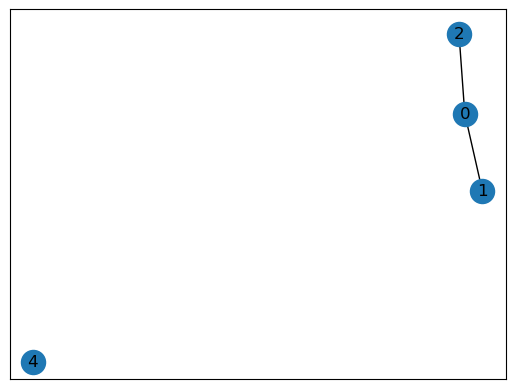

In [431]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
G.add_node(4)
nx.draw_networkx(G)
plt.show()
